<a href="https://colab.research.google.com/github/r-meleshko/kaggle/blob/main/dog_breed_identification_scratch_chatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup working environment

In [ ]:
from google.colab import files

uploaded = files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# 2. Download data

In [ ]:
!kaggle competitions download -c dog-breed-identification
!unzip dog-breed-identification.zip
!mkdir models

100% 690M/691M [00:32<00:00, 25.0MB/s]
100% 691M/691M [00:32<00:00, 22.5MB/s]
Archive:  dog-breed-identification.zip
caution: filename not matched:  -qq


#3. Data preprocessing

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load labels
labels = pd.read_csv( "labels.csv")
labels.id = labels.id.apply(lambda x: f"{x}.jpg")
labels.head(2)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo


(375, 500, 3)


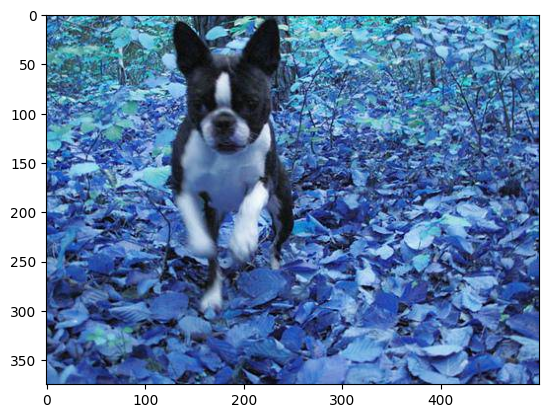

In [ ]:
import cv2

# Checkout one image
image = cv2.imread( f'train/{labels.loc[0, "id"]}', cv2.IMREAD_COLOR)
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_df, validation_df = train_test_split(labels, stratify=labels['breed'], test_size=0.2, random_state=420)


img_height, img_width = 224, 224
batch_size = 32

# Create a data generator with data augmentaiton
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)


# Prepare the generators for train and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col="id",
    y_col="breed",
    target_size=(img_height, img_width),
    class_mode="categorical",
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory='train',
    x_col="id",
    y_col="breed",
    target_size=(img_height, img_width),
    class_mode="categorical",
    batch_size=batch_size
)


# Create test generator
test_filenames = os.listdir('test')
test_df = pd.DataFrame({
    'id': test_filenames
})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # the dataframe for the test set will be created later
    directory='test',
    x_col="id",
    class_mode=None,  # no labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # keep data in the same order as filenames
)


Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.
Found 10357 validated image filenames.


# 4. Models

## Simple convnet

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import layers

inputs = layers.Input(shape=(img_height, img_width, 3))

x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPool2D(pool_size=2)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPool2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dense(units=512, activation="relu")(x)
outputs = layers.Dense(units=120, activation="softmax")(x)

model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496 

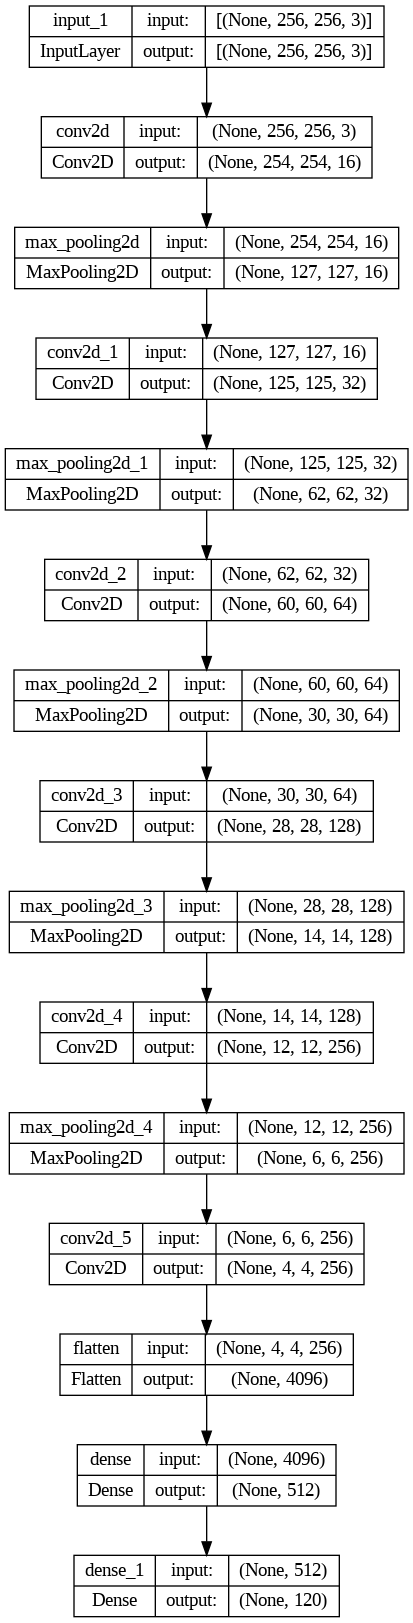

In [ ]:
from tensorflow import keras

!mkdir drive/MyDrive/kaggle/dog-breed-identification/models
keras.utils.plot_model(model, wd / "models/simple_convnet.png", show_shapes=True)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_generator,
    batch_size=32,
    epochs=10,
#    callbacks=callbacks_list
    validation_data=validation_generator,
)

Chat GPT from scratch model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Fourth convolutional block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout for regularization
    Dense(120, activation='softmax') # 120 classes for dog breeds
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 128)     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
import time

# The path where you want to save the model
filepath = "models/chatgpt_model.h5"

# Define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, mode='max')
checkpoint = ModelCheckpoint(str(filepath), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()


callbacks_list = [earlystop, checkpoint, time_callback]

# Training the model
history = model.fit(
    train_generator,
    epochs=20,  # The number of epochs you want to train
    validation_data=validation_generator,
    callbacks=callbacks_list
)

In [ ]:
np.mean(time_callback.times)

159.8288933634758